# 

## 모듈 불러오기

In [1]:
import os, re 
import numpy as np
import tensorflow as tf

## `raw_corpus`

In [2]:
file_path = '../../data/exploration_06/data/shakespeare.txt'
with open(file_path, "r") as f:
    raw_corpus = f.read().splitlines()

print(raw_corpus[:9])

['First Citizen:', 'Before we proceed any further, hear me speak.', '', 'All:', 'Speak, speak.', '', 'First Citizen:', 'You are all resolved rather to die than to famish?', '']


## `corpus`

In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

In [4]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)

corpus[:10]

['<start> before we proceed any further , hear me speak . <end>',
 '<start> speak , speak . <end>',
 '<start> you are all resolved rather to die than to famish ? <end>',
 '<start> resolved . resolved . <end>',
 '<start> first , you know caius marcius is chief enemy to the people . <end>',
 '<start> we know t , we know t . <end>',
 '<start> let us kill him , and we ll have corn at our own price . <end>',
 '<start> is t a verdict ? <end>',
 '<start> no more talking on t let it be done away , away ! <end>',
 '<start> one word , good citizens . <end>']

In [5]:
len(corpus)

24015

## `tensor`

In [6]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=7000, filters=' ', oov_token="<unk>")
tokenizer.fit_on_texts(corpus)
tensor = tokenizer.texts_to_sequences(corpus)
print(type(tensor))
print(np.array(tensor))
print(np.array([len(sentence) for sentence in tensor]).max())
tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')#,maxlen = 10)
print(type(tensor))
print(tensor.shape)

<class 'list'>
[list([2, 143, 40, 933, 140, 591, 4, 124, 24, 110, 5, 3])
 list([2, 110, 4, 110, 5, 3])
 list([2, 11, 50, 43, 1201, 316, 9, 201, 74, 9, 3034, 15, 3]) ...
 list([2, 149, 4553, 4, 3])
 list([2, 34, 71, 132, 39, 328, 390, 201, 4, 316, 2965, 132, 3])
 list([2, 945, 34, 134, 1787, 5, 3])]
21
<class 'numpy.ndarray'>
(24015, 21)


/tmp/ipykernel_87/369123024.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(tensor))


In [7]:
print(len(corpus))
print(tensor.shape) #24015개의 문장, 각 문장은 21차원의 벡터
print(corpus[0])
print(corpus[1])
print(corpus[2])
print(tensor[0])
print(tensor[1])
print(tensor[2])

24015
(24015, 21)
<start> before we proceed any further , hear me speak . <end>
<start> speak , speak . <end>
<start> you are all resolved rather to die than to famish ? <end>
[  2 143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0
   0   0   0]
[  2 110   4 110   5   3   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
[   2   11   50   43 1201  316    9  201   74    9 3034   15    3    0
    0    0    0    0    0    0    0]


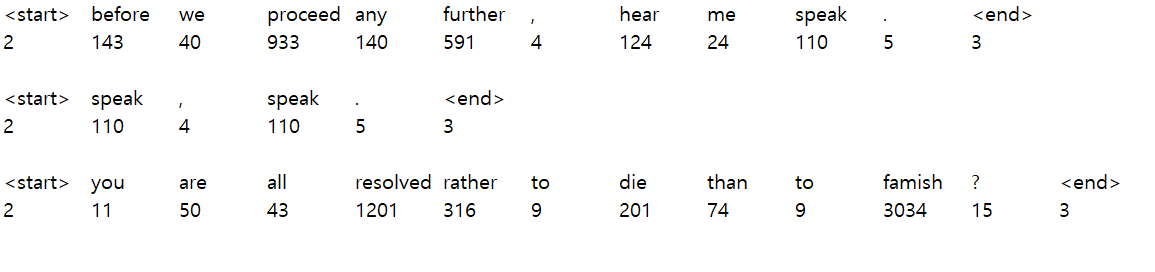

In [8]:
src_input = tensor[:, :-1]  
tgt_input = tensor[:, 1:]    
print(src_input[0])
print(tgt_input[0])

[  2 143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0
   0   0]
[143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0   0
   0   0]


## `dataset`

In [9]:
BUFFER_SIZE = len(src_input)
print('BUFFER_SIZE :',BUFFER_SIZE)
BATCH_SIZE = 256
print('BATCH_SIZE :',BATCH_SIZE)
steps_per_epoch = len(src_input) // BATCH_SIZE
print('steps_per_epoch :',steps_per_epoch)
VOCAB_SIZE = tokenizer.num_words + 1
print('VOCAB_SIZE :',VOCAB_SIZE)

BUFFER_SIZE : 24015
BATCH_SIZE : 256
steps_per_epoch : 93
VOCAB_SIZE : 7001


In [10]:
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset_as_np_array = np.array([data for data in dataset])
print(dataset_as_np_array.shape)
dataset = dataset.shuffle(BUFFER_SIZE)
dataset_as_np_array = np.array([data for data in dataset])
print(dataset_as_np_array.shape)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset_as_np_array = np.array([data for data in dataset])
print(dataset_as_np_array.shape)
print(dataset)

(24015, 2, 20)
(24015, 2, 20)
(93, 2, 256, 20)
<BatchDataset shapes: ((256, 20), (256, 20)), types: (tf.int32, tf.int32)>


## `model`

In [11]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

In [12]:
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [13]:
for src_sample, tgt_sample in dataset.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 20, 7001), dtype=float32, numpy=
array([[[ 8.35573301e-05, -4.40511387e-04,  2.13249834e-04, ...,
         -1.82419593e-04, -1.29691543e-04, -1.06802516e-04],
        [ 5.30666148e-04, -6.71166985e-04,  1.21158468e-04, ...,
         -6.81194593e-04, -1.78906354e-04, -5.07732038e-05],
        [ 5.92774944e-04, -8.49050994e-04, -1.74277830e-05, ...,
         -8.44632625e-04,  3.93648043e-05,  3.16660298e-04],
        ...,
        [ 2.35038460e-03, -3.25079542e-04,  2.32107309e-03, ...,
         -1.88126462e-03,  8.89205316e-04, -2.56098923e-03],
        [ 2.51277536e-03, -3.56691336e-04,  2.48600170e-03, ...,
         -2.06719222e-03,  8.81193613e-04, -2.74633639e-03],
        [ 2.65593850e-03, -3.88359127e-04,  2.62481812e-03, ...,
         -2.23539933e-03,  8.61225417e-04, -2.90400791e-03]],

       [[ 8.35573301e-05, -4.40511387e-04,  2.13249834e-04, ...,
         -1.82419593e-04, -1.29691543e-04, -1.06802516e-04],
        [ 2.08109734e-04, -7.67968944e-04,  3.

In [14]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1792256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  7176025   
Total params: 22,607,961
Trainable params: 22,607,961
Non-trainable params: 0
_________________________________________________________________


In [15]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,reduction='none')

In [16]:
model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset, epochs=30)

Epoch 1/30
93/93 [==============================] - 20s 169ms/step - loss: 3.6020
Epoch 2/30
93/93 [==============================] - 16s 174ms/step - loss: 2.8390
Epoch 3/30
93/93 [==============================] - 17s 179ms/step - loss: 2.7717
Epoch 4/30
93/93 [==============================] - 17s 185ms/step - loss: 2.6970
Epoch 5/30
93/93 [==============================] - 18s 194ms/step - loss: 2.6236
Epoch 6/30
93/93 [==============================] - 18s 196ms/step - loss: 2.5684
Epoch 7/30
93/93 [==============================] - 18s 189ms/step - loss: 2.5215
Epoch 8/30
93/93 [==============================] - 17s 187ms/step - loss: 2.4760
Epoch 9/30
93/93 [==============================] - 18s 188ms/step - loss: 2.4301
Epoch 10/30
93/93 [==============================] - 18s 191ms/step - loss: 2.3883
Epoch 11/30
93/93 [==============================] - 18s 192ms/step - loss: 2.3472
Epoch 12/30
93/93 [==============================] - 18s 190ms/step - loss: 2.3086
Epoch 13/30
9

## `generate_text`

In [17]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]
    while True:
        predict = model(test_tensor) 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [18]:
generate_text(model, tokenizer, init_sentence="<start> he sat on")

'<start> he sat on the <unk> , and my son s son , <end> '